In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import os
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
len(os.listdir("../input/march-machine-learning-mania-2024/"))

32

In [4]:
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2024/'
tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv")
seeds =pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
regular_results =pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv")

In [5]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [6]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [7]:
boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [8]:
# season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()

In [9]:
season_statistics.columns.values
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,...,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,...,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,...,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,...,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,...,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,...,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [10]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [11]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [12]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [13]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [14]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [15]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)

In [16]:
regular_season_effects.shape

(226482, 5)

In [17]:
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')

In [18]:
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(12300, 5)

In [19]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [20]:
years = []
for i in range(2003,2025):
    if i!=2020:
        years.append(i)

In [21]:
glm_quality = pd.DataFrame()
for year in years:
    print(year)
    glm_quality = pd.concat([glm_quality, team_quality(year)])
glm_quality = glm_quality.reset_index(drop=True)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2021
2022
2023
2024


In [22]:
glm_quality.head()

,TeamID,quality,Season
0,1104,-2.317591e-15,2003
1,1112,1.596216e+00,2003
2,1113,-1.043742e+00,2003
3,1120,-1.130995e+00,2003
4,1122,-1.263575e-01,2003


In [23]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [24]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [25]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [26]:
seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [27]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [28]:
tourney_data["T1_seed"] = pd.to_numeric(tourney_data["T1_seed"], errors='coerce')
tourney_data["T2_seed"] = pd.to_numeric(tourney_data["T2_seed"], errors='coerce')

tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]


In [29]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [30]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2630.000000
mean        0.000000
std        14.379336
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
dtype: float64

In [31]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [32]:
num_rows = dtrain.num_row()
num_cols = dtrain.num_col()
shape = (num_rows, num_cols)
size = num_rows * num_cols

print("Shape of dtrain: ", shape)
print("Size of dtrain: ", size)

Shape of dtrain:  (2630, 45)
Size of dtrain:  118350


In [33]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [34]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
# param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [35]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.41859+0.11843	test-mae:11.42676+0.49979
[50]	train-mae:9.08710+0.08925	test-mae:9.46881+0.40532
[100]	train-mae:8.57682+0.08334	test-mae:9.29093+0.37325
[150]	train-mae:8.24025+0.07341	test-mae:9.25282+0.36612
[200]	train-mae:7.96638+0.07407	test-mae:9.24139+0.34452
[205]	train-mae:7.94157+0.07187	test-mae:9.23951+0.34554
Fold repeater 1
[0]	train-mae:11.41353+0.03884	test-mae:11.42374+0.15865
[50]	train-mae:9.06035+0.02421	test-mae:9.48819+0.14707
[100]	train-mae:8.54341+0.02334	test-mae:9.31587+0.13980
[150]	train-mae:8.21836+0.01715	test-mae:9.28123+0.14077
[200]	train-mae:7.94162+0.01411	test-mae:9.26153+0.14781
[222]	train-mae:7.83453+0.01387	test-mae:9.26285+0.15511
Fold repeater 2
[0]	train-mae:11.41179+0.07315	test-mae:11.42170+0.29302
[50]	train-mae:9.06616+0.03774	test-mae:9.48394+0.07042
[100]	train-mae:8.55357+0.04076	test-mae:9.30406+0.12272
[150]	train-mae:8.21953+0.03917	test-mae:9.27745+0.15603
[200]	train-mae:7.94627+0.04766	test-mae:9.

In [36]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([180, 198, 220], [9.236134422845259, 9.258830845877245, 9.249488580974788])

In [37]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [38]:
len(oof_preds[0])

2630

In [39]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)

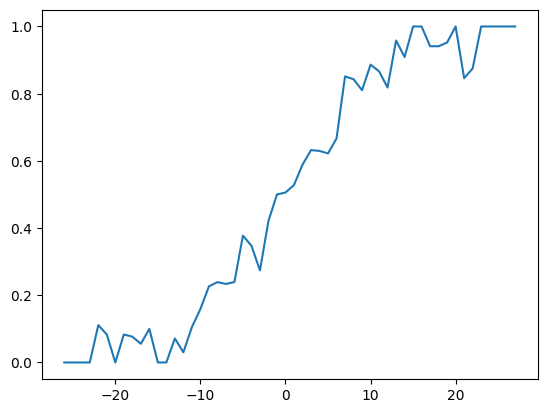

In [40]:
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')
plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [41]:
import math

In [42]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
      
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5683807879757475
logloss of cvsplit 1: 0.5715683133754691
logloss of cvsplit 2: 0.570725081007007


In [43]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)

In [44]:
plot_df.head()

,pred,label,spline,pred_int
0,-0.333594,1,0.485898,0
1,16.466961,1,0.956739,16
2,-5.800594,1,0.295058,-5
3,-21.639421,1,0.039645,-21
4,-1.978677,1,0.426792,-1


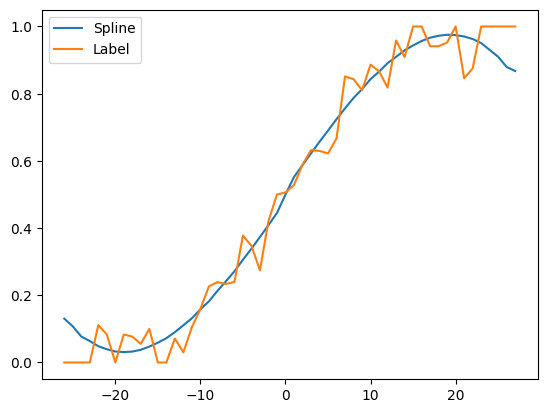

In [45]:
plot_df = plot_df.groupby('pred_int')[['spline', 'label']].mean().reset_index()
plt.figure()
plt.plot(plot_df['pred_int'], plot_df['spline'], label='Spline')
plt.plot(plot_df['pred_int'], plot_df['label'], label='Label')
plt.legend()
plt.show()

In [46]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.568381042718267
adjusted logloss of cvsplit 1: 0.5715683133754691
adjusted logloss of cvsplit 2: 0.5706433614574297


In [47]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.568381042718267
adjusted logloss of cvsplit 1: 0.5715683133754691
adjusted logloss of cvsplit 2: 0.5706433614574297


In [48]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [49]:
latest_seed=pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')

In [50]:
latest_seed_w = latest_seed.iloc[0:16].reset_index(drop=True)  # First 16 rows
latest_seed_x = latest_seed.iloc[16:32].reset_index(drop=True) # Next 16 rows
latest_seed_y = latest_seed.iloc[32:48].reset_index(drop=True) # Next 16 rows
latest_seed_z = latest_seed.iloc[48:64].reset_index(drop=True) # Next 16 rows

In [51]:
latest_seed_w.head()

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361


In [ ]:
def predict_distribution(round_number):
    days=[[136,137],[138,139],[143,144],[145,146],[152],[154]]
    tourney=pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneyCompactResults.csv")
    sed=pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySeeds.csv")
    tourney = tourney[["Season", "DayNum", "WTeamID"]]
    if round_number<=4:
        tourney= tourney[(tourney['DayNum'] == days[round_number-1][0]) | (tourney['DayNum'] == days[round_number-1][1])]
    else:
        tourney= tourney[(tourney['DayNum'] == days[round_number-1][0]) ]
    tourney.columns.values[2]='TeamID'
    seedlist=[]
    for i in range(0,len(tourney)):
        filtered_row = sed[(sed['Season'] == tourney.iloc[i]['Season']) & (sed['TeamID'] == tourney.iloc[i,2])]
        if not filtered_row.empty:
            seedlist.append(filtered_row['Seed'].iloc[0])
        else:
            print("maybe there is an error")
    tourney['Seed']=seedlist
    tourney['Seed']=tourney['Seed'].apply(lambda x: x[1:3])
    tourney['Seed'] = tourney['Seed'].astype(int)
    counts = tourney['Seed'].value_counts()
    print('total_counts: ',counts.sum())
    seeds_range = range(1, 17)  # Seeds from 1 to 16
    seed_counts = [counts.get(seed, 0) for seed in seeds_range]
    seed_counts=np.array(seed_counts)
    counts_values_log = np.log1p(seed_counts)  # log1p is used to apply log(1+x) to handle zero values gracefully
    plt.figure(figsize=(10, 6))

#     Plotting the original histogram
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.bar(seeds_range, seed_counts, color='skyblue')
    plt.xlabel('Seed')
    plt.ylabel('Count')
    plt.title('Original Histogram')
    plt.xticks(rotation=90)

    # Plotting the log-transformed histogram
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.bar(seeds_range, counts_values_log, color='lightgreen')
    plt.xlabel('Seed')
    plt.ylabel('Log-Transformed Count')
    plt.title('Log-Transformed Histogram')
    plt.xticks(rotation=90)

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()
    return seed_counts/counts.sum(),counts_values_log
counts=[]
for i in range(1,7):
    counts.append(predict_distribution(i))

In [ ]:
LEVELS = [
    ['R1W1', 'R1W2', 'R1W3', 'R1W4', 'R1W5', 'R1W6', 'R1W7', 'R1W8', 'R1X1', 'R1X2', 'R1X3', 'R1X4', 'R1X5', 'R1X6', 'R1X7', 'R1X8', 'R1Y1', 'R1Y2', 'R1Y3', 'R1Y4', 'R1Y5', 'R1Y6', 'R1Y7', 'R1Y8', 'R1Z1', 'R1Z2', 'R1Z3', 'R1Z4', 'R1Z5', 'R1Z6', 'R1Z7', 'R1Z8'], 
    ['R2W1', 'R2W2', 'R2W3', 'R2W4', 'R2X1', 'R2X2', 'R2X3', 'R2X4', 'R2Y1', 'R2Y2', 'R2Y3', 'R2Y4', 'R2Z1', 'R2Z2', 'R2Z3', 'R2Z4'],
    ['R3W1', 'R3W2', 'R3X1', 'R3X2', 'R3Y1', 'R3Y2', 'R3Z1', 'R3Z2'], 
    ['R4W1', 'R4X1', 'R4Y1', 'R4Z1'], 
    ['R5WX', 'R5YZ'], 
    ['R6CH'],
]

# Function to reorganize each level based on the suffixes ("W1" with "X1", "Y1", "Z1", etc.)
def reorganize_level(level):
    # Dictionary to hold groups of items by their suffix
    suffix_groups = {}
    for item in level:
        # Extract the suffix (last character) to group by
        suffix = item[-1]
        if suffix.isdigit():  # Check if the suffix is a digit to handle special cases like 'R5WX', 'R5YZ', 'R6CH'
            if suffix not in suffix_groups:
                suffix_groups[suffix] = []
            suffix_groups[suffix].append(item)
        else:  # Handle special cases by directly adding them to the reorganized level
            if 'special' not in suffix_groups:  # Use a special key for these cases
                suffix_groups['special'] = []
            suffix_groups['special'].append(item)
    
    # Combine the grouped items into a new level, maintaining the order based on the suffix
    new_level = []
    for suffix in sorted(suffix_groups.keys()):  # Sort keys to maintain order
        new_level.extend(sorted(suffix_groups[suffix]))  # Sort each group to maintain 'W', 'X', 'Y', 'Z' order
    return new_level

# Apply the reorganization to each level in LEVELS
new_levels = [reorganize_level(level) for level in LEVELS]
levels = np.concatenate([np.array(level) for level in new_levels])

In [ ]:
len(levels)

In [ ]:
# winner2023=[
#     'W16', 'W09', 'W05', 'W04', 'W06', 'W03', 'W07', 'W02',
#     'X07', 'X15', 'X06', 'X03', 'X05', 'X13', 'X01', 'X08',
#     'Y01', 'Y09', 'Y05', 'Y04', 'Y03', 'Y11', 'Y10', 'Y02',
#     'Z01', 'Z08', 'Z05', 'Z04', 'Z06', 'Z03', 'Z07', 'Z02'
# ]
# winner2023=["W07", "W03", "W04", "W09", "X06", "X15", "X01", "X05", "Y01", "Y05", "Y03", "Y02", "Z08", "Z04", "Z03", "Z02"]
# winner2023=["W09", "W03", "X05", "X06", "Y05", "Y02", "Z04", "Z03"]
winner2023=["W09","X05","Y05","Z04"]
winner2023=np.array(winner2023)

In [ ]:
alpha_list=[]
loss_list=[]

In [ ]:
def winner_prediction(matches,alpha,round_no):
    winner=[]
    columns = ['Season', 'T1_TeamID', 'T2_TeamID','T1_Seed','T2_Seed']
    sub = pd.DataFrame(matches, columns=columns)
    sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    sub["T1_seed"] = pd.to_numeric(sub["T1_seed"], errors='coerce')
    sub["T2_seed"] = pd.to_numeric(sub["T2_seed"], errors='coerce')
    sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
    Xsub = sub[features].values
    dtest = xgb.DMatrix(Xsub)
    sub_preds = []
    for i in range(repeat_cv):
        sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
    winner=[]
    for i in range(0,32//(2**(round_no-1))):
        rand = np.random.uniform(0, 1)
        x,y=int(sub.iloc[i,3][1:3]),int(sub.iloc[i,4][1:3])
        p2=max(counts[round_no-1][0][x-1],counts[round_no-1][0][y-1])
        p1=sub.iloc[i,50]
        p = (p1 * alpha) + (p2 * (1 - alpha))
        if rand<p:
            winner.append(sub.iloc[i,3])
        else:
            winner.append(sub.iloc[i,4])
    return winner

In [ ]:
def make_brackets_for_men():
    win=[]
    matches=[]
    for i in range(0,8):
        matches.append([2024,latest_seed_w.iloc[i,2],latest_seed_w.iloc[16-i-1,2],latest_seed_w.iloc[i,1],latest_seed_w.iloc[16-i-1,1]])
        matches.append([2024,latest_seed_x.iloc[i,2],latest_seed_x.iloc[16-i-1,2],latest_seed_x.iloc[i,1],latest_seed_x.iloc[16-i-1,1]])
        matches.append([2024,latest_seed_y.iloc[i,2],latest_seed_y.iloc[16-i-1,2],latest_seed_y.iloc[i,1],latest_seed_y.iloc[16-i-1,1]])
        matches.append([2024,latest_seed_z.iloc[i,2],latest_seed_z.iloc[16-i-1,2],latest_seed_z.iloc[i,1],latest_seed_z.iloc[16-i-1,1]])
    winner=winner_prediction(matches,0.99,1)
    win=win+winner
    latest_seed_w2 = latest_seed_w.iloc[0:8].reset_index(drop=True) 
    latest_seed_x2 = latest_seed_x.iloc[0:8].reset_index(drop=True) 
    latest_seed_y2 = latest_seed_y.iloc[0:8].reset_index(drop=True)
    latest_seed_z2 = latest_seed_z.iloc[0:8].reset_index(drop=True)
    for i in range(0,8):
        if winner[4*i]!= latest_seed_w2.iloc[i,1]:
            latest_seed_w2.iloc[i]=latest_seed_w.iloc[16-i-1]
        if winner[4*i+1]!= latest_seed_x2.iloc[i,1]:
            latest_seed_x2.iloc[i]=latest_seed_x.iloc[16-i-1]
        if winner[4*i+2]!= latest_seed_y2.iloc[i,1]:
            latest_seed_y2.iloc[i]=latest_seed_y.iloc[16-i-1]
        if winner[4*i+3]!= latest_seed_z2.iloc[i,1]:
            latest_seed_z2.iloc[i]=latest_seed_z.iloc[16-i-1]
    matches=[]
#     print(winner)
#     print(latest_seed_w2)
    for i in range(0,4):
        matches.append([2024,latest_seed_w2.iloc[i,2],latest_seed_w2.iloc[8-i-1,2],latest_seed_w2.iloc[i,1],latest_seed_w2.iloc[8-i-1,1]])
        matches.append([2024,latest_seed_x2.iloc[i,2],latest_seed_x2.iloc[8-i-1,2],latest_seed_x2.iloc[i,1],latest_seed_x2.iloc[8-i-1,1]])
        matches.append([2024,latest_seed_y2.iloc[i,2],latest_seed_y2.iloc[8-i-1,2],latest_seed_y2.iloc[i,1],latest_seed_y2.iloc[8-i-1,1]])
        matches.append([2024,latest_seed_z2.iloc[i,2],latest_seed_z2.iloc[8-i-1,2],latest_seed_z2.iloc[i,1],latest_seed_z2.iloc[8-i-1,1]])
    winner=winner_prediction(matches,0.98,2)
    win=win+winner
    latest_seed_w3 = latest_seed_w2.iloc[0:4].reset_index(drop=True) 
    latest_seed_x3 = latest_seed_x2.iloc[0:4].reset_index(drop=True) 
    latest_seed_y3 = latest_seed_y2.iloc[0:4].reset_index(drop=True)
    latest_seed_z3 = latest_seed_z2.iloc[0:4].reset_index(drop=True)
    for i in range(0,4):
        if winner[4*i]!= latest_seed_w3.iloc[i,1]:
            latest_seed_w3.iloc[i]=latest_seed_w2.iloc[8-i-1]
        if winner[4*i+1]!= latest_seed_x3.iloc[i,1]:
            latest_seed_x3.iloc[i]=latest_seed_x2.iloc[8-i-1]
        if winner[4*i+2]!= latest_seed_y3.iloc[i,1]:
            latest_seed_y3.iloc[i]=latest_seed_y2.iloc[8-i-1]
        if winner[4*i+3]!= latest_seed_z3.iloc[i,1]:
            latest_seed_z3.iloc[i]=latest_seed_z2.iloc[8-i-1]
    matches=[]
#     print(winner)
#     print(latest_seed_w3)
    for i in range(0,2):
        matches.append([2024,latest_seed_w3.iloc[i,2],latest_seed_w3.iloc[4-i-1,2],latest_seed_w3.iloc[i,1],latest_seed_w3.iloc[4-i-1,1]])
        matches.append([2024,latest_seed_x3.iloc[i,2],latest_seed_x3.iloc[4-i-1,2],latest_seed_x3.iloc[i,1],latest_seed_x3.iloc[4-i-1,1]])
        matches.append([2024,latest_seed_y3.iloc[i,2],latest_seed_y3.iloc[4-i-1,2],latest_seed_y3.iloc[i,1],latest_seed_y3.iloc[4-i-1,1]])
        matches.append([2024,latest_seed_z3.iloc[i,2],latest_seed_z3.iloc[4-i-1,2],latest_seed_z3.iloc[i,1],latest_seed_z3.iloc[4-i-1,1]])
    winner=winner_prediction(matches,0.01,3)
    win=win+winner
    latest_seed_w4 = latest_seed_w3.iloc[0:2].reset_index(drop=True) 
    latest_seed_x4 = latest_seed_x3.iloc[0:2].reset_index(drop=True) 
    latest_seed_y4 = latest_seed_y3.iloc[0:2].reset_index(drop=True)
    latest_seed_z4 = latest_seed_z3.iloc[0:2].reset_index(drop=True)
    for i in range(0,2):
        if winner[4*i]!= latest_seed_w4.iloc[i,1]:
            latest_seed_w4.iloc[i]=latest_seed_w3.iloc[4-i-1]
        if winner[4*i+1]!= latest_seed_x4.iloc[i,1]:
            latest_seed_x4.iloc[i]=latest_seed_x3.iloc[4-i-1]
        if winner[4*i+2]!= latest_seed_y4.iloc[i,1]:
            latest_seed_y4.iloc[i]=latest_seed_y3.iloc[4-i-1]
        if winner[4*i+3]!= latest_seed_z4.iloc[i,1]:
            latest_seed_z4.iloc[i]=latest_seed_z3.iloc[4-i-1]
    matches=[]
#     print(winner)
#     print(latest_seed_w4)
    for i in range(0,1):
        matches.append([2024,latest_seed_w4.iloc[i,2],latest_seed_w4.iloc[2-i-1,2],latest_seed_w4.iloc[i,1],latest_seed_w4.iloc[2-i-1,1]])
        matches.append([2024,latest_seed_x4.iloc[i,2],latest_seed_x4.iloc[2-i-1,2],latest_seed_x4.iloc[i,1],latest_seed_x4.iloc[2-i-1,1]])
        matches.append([2024,latest_seed_y4.iloc[i,2],latest_seed_y4.iloc[2-i-1,2],latest_seed_y4.iloc[i,1],latest_seed_y4.iloc[2-i-1,1]])
        matches.append([2024,latest_seed_z4.iloc[i,2],latest_seed_z4.iloc[2-i-1,2],latest_seed_z4.iloc[i,1],latest_seed_z4.iloc[2-i-1,1]])
    winner=winner_prediction(matches,0.03,4)
    win=win+winner
    matches=[]
    latest_seed_w4 = latest_seed_w4[latest_seed_w4['Seed'] == winner[0]]
    latest_seed_x4 = latest_seed_x4[latest_seed_x4['Seed'] == winner[1]]
    latest_seed_y4 = latest_seed_y4[latest_seed_y4['Seed'] == winner[2]]
    latest_seed_z4 = latest_seed_z4[latest_seed_z4['Seed'] == winner[3]]
    matches.append([2024,latest_seed_w4.iloc[0,2],latest_seed_x4.iloc[0,2],latest_seed_w4.iloc[0,1],latest_seed_x4.iloc[0,1]])
    matches.append([2024,latest_seed_y4.iloc[0,2],latest_seed_z4.iloc[0,2],latest_seed_y4.iloc[0,1],latest_seed_z4.iloc[0,1]])
    winner=winner_prediction(matches,0.01,5)
    win=win+winner
#         print(winner)
#         print(matches)
    if 'X' in winner[0]:
        final_seed1=latest_seed_x4
    else:
        final_seed1=latest_seed_w4
    if 'Y' in winner[1]:
        final_seed2=latest_seed_y4
    else:
        final_seed2=latest_seed_z4
    matches=[]
    matches.append([2024,final_seed1.iloc[0,2],final_seed2.iloc[0,2],final_seed1.iloc[0,1],final_seed2.iloc[0,1]])
    winner=winner_prediction(matches,0.01,6)
    win=win+winner
    return win

In [ ]:
tournaments=['M']*63
brackets=[]
for i in range(0,10000):
    if i%50==0:
        print(i)
    columns = ["Tournament", "Bracket", "Slot", "Team"]
    df = pd.DataFrame(columns=columns)
    df["Tournament"]=tournaments
    df['Bracket']=[i+1]*63
    df['Slot']=levels
    df['Team']=make_brackets_for_men()
    brackets.append(df)

In [ ]:
def Women_bracket():
    DATA_PATH = '/kaggle/input/march-machine-learning-mania-2024/'
    tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv")
    seeds =pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
    regular_results =pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
    def prepare_data(df):
        dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
        'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

        dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
        dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
        df.columns.values[6] = 'location'
        dfswap.columns.values[6] = 'location'    

        df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
        dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

        output = pd.concat([df, dfswap]).reset_index(drop=True)
        output.loc[output.location=='N','location'] = '0'
        output.loc[output.location=='H','location'] = '1'
        output.loc[output.location=='A','location'] = '-1'
        output.location = output.location.astype(int)

        output['PointDiff'] = output['T1_Score'] - output['T2_Score']

        return output
    regular_data = prepare_data(regular_results)
    tourney_data = prepare_data(tourney_results)
    boxscore_cols = [
            'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
            'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
            'PointDiff']

    funcs = [np.mean]
    # season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
    season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
    season_statistics.columns.values
    season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
    season_statistics.head()
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

    season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
    season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
    season_statistics_T1.columns.values[0] = "Season"
    season_statistics_T2.columns.values[0] = "Season"
    tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
    tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
    last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
    last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

    last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
    last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
    last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')
    tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
    regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
    regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
    regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
    march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
    march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
    march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
    march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
    regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
    def team_quality(season):
        formula = 'win~-1+T1_TeamID+T2_TeamID'
        glm = sm.GLM.from_formula(formula=formula, 
                                  data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                                  family=sm.families.Binomial()).fit()

        quality = pd.DataFrame(glm.params).reset_index()
        quality.columns = ['TeamID','quality']
        quality['Season'] = season
        #quality['quality'] = np.exp(quality['quality'])
        quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
        quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
        return quality
    glm_quality = pd.concat([team_quality(2010),
                             team_quality(2011),
                             team_quality(2012),
                             team_quality(2013),
                             team_quality(2014),
                             team_quality(2015),
                             team_quality(2016),
                             team_quality(2017),
                             team_quality(2018),
                             team_quality(2019),
                             ##team_quality(2020),
                             team_quality(2021),
                             team_quality(2022),
                             team_quality(2023)
                             ]).reset_index(drop=True)
    glm_quality_T1 = glm_quality.copy()
    glm_quality_T2 = glm_quality.copy()
    glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
    glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']
    tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds_T1 = seeds[['Season','TeamID','Seed']].copy()
    seeds_T2 = seeds[['Season','TeamID','Seed']].copy()
    seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
    seeds_T2.columns = ['Season','T2_TeamID','T2_seed']
    tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    tourney_data["T1_seed"] = pd.to_numeric(tourney_data["T1_seed"], errors='coerce')
    tourney_data["T2_seed"] = pd.to_numeric(tourney_data["T2_seed"], errors='coerce')

    tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
    features = list(season_statistics_T1.columns[2:999]) + \
        list(season_statistics_T2.columns[2:999]) + \
        list(seeds_T1.columns[2:999]) + \
        list(seeds_T2.columns[2:999]) + \
        list(last14days_stats_T1.columns[2:999]) + \
        list(last14days_stats_T2.columns[2:999]) + \
        ["Seed_diff"] + ["T1_quality","T2_quality"]
    y = tourney_data['T1_Score'] - tourney_data['T2_Score']
    X = tourney_data[features].values
    dtrain = xgb.DMatrix(X, label = y)
    def cauchyobj(preds, dtrain):
        labels = dtrain.get_label()
        c = 5000 
        x =  preds-labels    
        grad = x / (x**2/c**2+1)
        hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
        return grad, hess
    param = {} 
    #param['objective'] = 'reg:linear'
    param['eval_metric'] =  'mae'
    param['booster'] = 'gbtree'
    param['eta'] = 0.05 #change to ~0.02 for final run
    param['subsample'] = 0.35
    param['colsample_bytree'] = 0.7
    param['num_parallel_tree'] = 3 #recommend 10
    param['min_child_weight'] = 40
    param['gamma'] = 10
    param['max_depth'] =  3
    # param['silent'] = 1
    xgb_cv = []
    repeat_cv = 3 # recommend 10
    for i in range(repeat_cv): 
        print(f"Fold repeater {i}")
        xgb_cv.append(
            xgb.cv(
              params = param,
              dtrain = dtrain,
              obj = cauchyobj,
              num_boost_round = 3000,
              folds = KFold(n_splits = 5, shuffle = True, random_state = i),
              early_stopping_rounds = 25,
              verbose_eval = 50
            )
        )
    iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
    val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
    oof_preds = []
    for i in range(repeat_cv):
        print(f"Fold repeater {i}")
        preds = y.copy()
        kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
        for train_index, val_index in kfold.split(X,y):
            dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
            dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
            model = xgb.train(
                  params = param,
                  dtrain = dtrain_i,
                  num_boost_round = iteration_counts[i],
                  verbose_eval = 50
            )
            preds[val_index] = model.predict(dval_i)
        oof_preds.append(np.clip(preds,-30,30))
    spline_model = []

    for i in range(repeat_cv):
        dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
        dat = sorted(dat, key = lambda x: x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]]= dat[k][1]
        spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model[i](oof_preds[i])
        spline_fit = np.clip(spline_fit,0.025,0.975)
        spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
        spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
        spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0

        print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    sub_models = []
    for i in range(repeat_cv):
        print(f"Fold repeater {i}")
        sub_models.append(
            xgb.train(
              params = param,
              dtrain = dtrain,
              num_boost_round = int(iteration_counts[i] * 1.05),
              verbose_eval = 50
            )
        )
    latest_seed=pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')
    latest_seed_w = latest_seed.iloc[64:80].reset_index(drop=True)  # First 16 rows
    latest_seed_x = latest_seed.iloc[80:96].reset_index(drop=True) # Next 16 rows
    latest_seed_y = latest_seed.iloc[96:112].reset_index(drop=True) # Next 16 rows
    latest_seed_z = latest_seed.iloc[112:128].reset_index(drop=True) # Next 16 rows
    tourney=pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/WNCAATourneyCompactResults.csv')
    seed = pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/WNCAATourneySeeds.csv")
    seed_adjusted = seed.rename(columns={'TeamID': 'WTeamID'})
    tourney_with_seeds = pd.merge(tourney, seed_adjusted, on=['Season', 'WTeamID'])
    tourney_with_seeds['WTeamSeed'] = tourney_with_seeds['Seed']
    tourney_with_seeds.drop(['Seed'], axis=1, inplace=True)
    year_wise_seed_count = tourney_with_seeds.groupby(['Season', 'WTeamSeed']).size().reset_index(name='Count')
    mask = year_wise_seed_count["WTeamSeed"].str.contains('a|b', regex=True)
    year_wise_seed_count.loc[mask, "WTeamSeed"] = year_wise_seed_count.loc[mask, "WTeamSeed"].str[0:3]
    counts=[]
    for i in range(0,16):
        counts.append([0,0,0,0,0,0])
    for i in range(0,len(year_wise_seed_count)):
        x=year_wise_seed_count.iloc[i,2]
        y=year_wise_seed_count.iloc[i,1]
        y=int(y[1:3])
        for i in range(0,x):
            counts[y-1][i]+=1
    counts=np.array(counts).T
    def winner_predictionforWomen(matches,alpha,round_no):
        winner=[]
        columns = ['Season', 'T1_TeamID', 'T2_TeamID','T1_Seed','T2_Seed']
        sub = pd.DataFrame(matches, columns=columns)
        sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
        sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')
        sub["T1_seed"] = pd.to_numeric(sub["T1_seed"], errors='coerce')
        sub["T2_seed"] = pd.to_numeric(sub["T2_seed"], errors='coerce')
        sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
        Xsub = sub[features].values
        dtest = xgb.DMatrix(Xsub)
        sub_preds = []
        for i in range(repeat_cv):
            sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
        sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
        winner=[]
        for i in range(0,32//(2**(round_no-1))):
            rand = np.random.uniform(0, 1)
            x,y=int(sub.iloc[i,3][1:3]),int(sub.iloc[i,4][1:3])
            p2=max(counts[round_no-1][x-1],counts[round_no-1][y-1])
            p1=sub.iloc[i,50]
            p = (p1 ** alpha) * (p2 ** (1 - alpha))
            if rand<p:
                winner.append(sub.iloc[i,3])
            else:
                winner.append(sub.iloc[i,4])
        return winner
    def make_brackets_for_women():
        win=[]
        matches=[]
        for i in range(0,8):
            matches.append([2024,latest_seed_w.iloc[i,2],latest_seed_w.iloc[16-i-1,2],latest_seed_w.iloc[i,1],latest_seed_w.iloc[16-i-1,1]])
            matches.append([2024,latest_seed_x.iloc[i,2],latest_seed_x.iloc[16-i-1,2],latest_seed_x.iloc[i,1],latest_seed_x.iloc[16-i-1,1]])
            matches.append([2024,latest_seed_y.iloc[i,2],latest_seed_y.iloc[16-i-1,2],latest_seed_y.iloc[i,1],latest_seed_y.iloc[16-i-1,1]])
            matches.append([2024,latest_seed_z.iloc[i,2],latest_seed_z.iloc[16-i-1,2],latest_seed_z.iloc[i,1],latest_seed_z.iloc[16-i-1,1]])
        winner=winner_predictionforWomen(matches,0.99,1)
        win=win+winner
        latest_seed_w2 = latest_seed_w.iloc[0:8].reset_index(drop=True) 
        latest_seed_x2 = latest_seed_x.iloc[0:8].reset_index(drop=True) 
        latest_seed_y2 = latest_seed_y.iloc[0:8].reset_index(drop=True)
        latest_seed_z2 = latest_seed_z.iloc[0:8].reset_index(drop=True)
        for i in range(0,8):
            if winner[4*i]!= latest_seed_w2.iloc[i,1]:
                latest_seed_w2.iloc[i]=latest_seed_w.iloc[16-i-1]
            if winner[4*i+1]!= latest_seed_x2.iloc[i,1]:
                latest_seed_x2.iloc[i]=latest_seed_x.iloc[16-i-1]
            if winner[4*i+2]!= latest_seed_y2.iloc[i,1]:
                latest_seed_y2.iloc[i]=latest_seed_y.iloc[16-i-1]
            if winner[4*i+3]!= latest_seed_z2.iloc[i,1]:
                latest_seed_z2.iloc[i]=latest_seed_z.iloc[16-i-1]
        matches=[]
    #     print(winner)
    #     print(latest_seed_w2)
        for i in range(0,4):
            matches.append([2024,latest_seed_w2.iloc[i,2],latest_seed_w2.iloc[8-i-1,2],latest_seed_w2.iloc[i,1],latest_seed_w2.iloc[8-i-1,1]])
            matches.append([2024,latest_seed_x2.iloc[i,2],latest_seed_x2.iloc[8-i-1,2],latest_seed_x2.iloc[i,1],latest_seed_x2.iloc[8-i-1,1]])
            matches.append([2024,latest_seed_y2.iloc[i,2],latest_seed_y2.iloc[8-i-1,2],latest_seed_y2.iloc[i,1],latest_seed_y2.iloc[8-i-1,1]])
            matches.append([2024,latest_seed_z2.iloc[i,2],latest_seed_z2.iloc[8-i-1,2],latest_seed_z2.iloc[i,1],latest_seed_z2.iloc[8-i-1,1]])
        winner=winner_predictionforWomen(matches,0.98,2)
        win=win+winner
        latest_seed_w3 = latest_seed_w2.iloc[0:4].reset_index(drop=True) 
        latest_seed_x3 = latest_seed_x2.iloc[0:4].reset_index(drop=True) 
        latest_seed_y3 = latest_seed_y2.iloc[0:4].reset_index(drop=True)
        latest_seed_z3 = latest_seed_z2.iloc[0:4].reset_index(drop=True)
        for i in range(0,4):
            if winner[4*i]!= latest_seed_w3.iloc[i,1]:
                latest_seed_w3.iloc[i]=latest_seed_w2.iloc[8-i-1]
            if winner[4*i+1]!= latest_seed_x3.iloc[i,1]:
                latest_seed_x3.iloc[i]=latest_seed_x2.iloc[8-i-1]
            if winner[4*i+2]!= latest_seed_y3.iloc[i,1]:
                latest_seed_y3.iloc[i]=latest_seed_y2.iloc[8-i-1]
            if winner[4*i+3]!= latest_seed_z3.iloc[i,1]:
                latest_seed_z3.iloc[i]=latest_seed_z2.iloc[8-i-1]
        matches=[]
    #     print(winner)
    #     print(latest_seed_w3)
        for i in range(0,2):
            matches.append([2024,latest_seed_w3.iloc[i,2],latest_seed_w3.iloc[4-i-1,2],latest_seed_w3.iloc[i,1],latest_seed_w3.iloc[4-i-1,1]])
            matches.append([2024,latest_seed_x3.iloc[i,2],latest_seed_x3.iloc[4-i-1,2],latest_seed_x3.iloc[i,1],latest_seed_x3.iloc[4-i-1,1]])
            matches.append([2024,latest_seed_y3.iloc[i,2],latest_seed_y3.iloc[4-i-1,2],latest_seed_y3.iloc[i,1],latest_seed_y3.iloc[4-i-1,1]])
            matches.append([2024,latest_seed_z3.iloc[i,2],latest_seed_z3.iloc[4-i-1,2],latest_seed_z3.iloc[i,1],latest_seed_z3.iloc[4-i-1,1]])
        winner=winner_predictionforWomen(matches,0.01,3)
        win=win+winner
        latest_seed_w4 = latest_seed_w3.iloc[0:2].reset_index(drop=True) 
        latest_seed_x4 = latest_seed_x3.iloc[0:2].reset_index(drop=True) 
        latest_seed_y4 = latest_seed_y3.iloc[0:2].reset_index(drop=True)
        latest_seed_z4 = latest_seed_z3.iloc[0:2].reset_index(drop=True)
        for i in range(0,2):
            if winner[4*i]!= latest_seed_w4.iloc[i,1]:
                latest_seed_w4.iloc[i]=latest_seed_w3.iloc[4-i-1]
            if winner[4*i+1]!= latest_seed_x4.iloc[i,1]:
                latest_seed_x4.iloc[i]=latest_seed_x3.iloc[4-i-1]
            if winner[4*i+2]!= latest_seed_y4.iloc[i,1]:
                latest_seed_y4.iloc[i]=latest_seed_y3.iloc[4-i-1]
            if winner[4*i+3]!= latest_seed_z4.iloc[i,1]:
                latest_seed_z4.iloc[i]=latest_seed_z3.iloc[4-i-1]
        matches=[]
    #     print(winner)
    #     print(latest_seed_w4)
        for i in range(0,1):
            matches.append([2024,latest_seed_w4.iloc[i,2],latest_seed_w4.iloc[2-i-1,2],latest_seed_w4.iloc[i,1],latest_seed_w4.iloc[2-i-1,1]])
            matches.append([2024,latest_seed_x4.iloc[i,2],latest_seed_x4.iloc[2-i-1,2],latest_seed_x4.iloc[i,1],latest_seed_x4.iloc[2-i-1,1]])
            matches.append([2024,latest_seed_y4.iloc[i,2],latest_seed_y4.iloc[2-i-1,2],latest_seed_y4.iloc[i,1],latest_seed_y4.iloc[2-i-1,1]])
            matches.append([2024,latest_seed_z4.iloc[i,2],latest_seed_z4.iloc[2-i-1,2],latest_seed_z4.iloc[i,1],latest_seed_z4.iloc[2-i-1,1]])
        winner=winner_predictionforWomen(matches,0.03,4)
        win=win+winner
        matches=[]
        latest_seed_w4 = latest_seed_w4[latest_seed_w4['Seed'] == winner[0]]
        latest_seed_x4 = latest_seed_x4[latest_seed_x4['Seed'] == winner[1]]
        latest_seed_y4 = latest_seed_y4[latest_seed_y4['Seed'] == winner[2]]
        latest_seed_z4 = latest_seed_z4[latest_seed_z4['Seed'] == winner[3]]
        matches.append([2024,latest_seed_w4.iloc[0,2],latest_seed_x4.iloc[0,2],latest_seed_w4.iloc[0,1],latest_seed_x4.iloc[0,1]])
        matches.append([2024,latest_seed_y4.iloc[0,2],latest_seed_z4.iloc[0,2],latest_seed_y4.iloc[0,1],latest_seed_z4.iloc[0,1]])
        winner=winner_predictionforWomen(matches,0.01,5)
        win=win+winner
    #         print(winner)
    #         print(matches)
        if 'X' in winner[0]:
            final_seed1=latest_seed_x4
        else:
            final_seed1=latest_seed_w4
        if 'Y' in winner[1]:
            final_seed2=latest_seed_y4
        else:
            final_seed2=latest_seed_z4
        matches=[]
        matches.append([2024,final_seed1.iloc[0,2],final_seed2.iloc[0,2],final_seed1.iloc[0,1],final_seed2.iloc[0,1]])
        winner=winner_predictionforWomen(matches,0.01,6)
        win=win+winner
        return win
    tournaments=['W']*63
    brackets=[]
    for i in range(0,10000):
        if i%50==0:
            print(i)
        columns = ["Tournament", "Bracket", "Slot", "Team"]
        df = pd.DataFrame(columns=columns)
        df["Tournament"]=tournaments
        df['Bracket']=[i+1]*63
        df['Slot']=levels
        df['Team']=make_brackets_for_women()
        brackets.append(df)
    return brackets

In [ ]:
bracket_women=Women_bracket()

In [ ]:
concatenated_dfs = [pd.concat([df1, df2], axis=0).reset_index(drop=True) for df1, df2 in zip(brackets, bracket_women)]
final_df = pd.concat(concatenated_dfs, axis=0).reset_index(drop=True)

In [ ]:
final_df.insert(0, 'RowId', final_df.index)

In [ ]:
final_df.to_csv('Submission.csv', index=False)

In [ ]:
# df=pd.read_csv('/kaggle/working/Submission final.csv')

In [ ]:
# df.head(252)

In [ ]:
# def predict_distribution(round_number):
#     days=[[136,137],[138,139],[143,144],[145,146],[152],[154]]
#     tourney=pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneyCompactResults.csv")
#     sed=pd.read_csv("/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySeeds.csv")
#     tourney = tourney[["Season", "DayNum", "WTeamID"]]
#     if round_number<=4:
#         tourney= tourney[(tourney['DayNum'] == days[round_number-1][0]) | (tourney['DayNum'] == days[round_number-1][1])]
#     else:
#         tourney= tourney[(tourney['DayNum'] == days[round_number-1][0]) ]
#     tourney.columns.values[2]='TeamID'
#     seedlist=[]
#     for i in range(0,len(tourney)):
#         filtered_row = sed[(sed['Season'] == tourney.iloc[i]['Season']) & (sed['TeamID'] == tourney.iloc[i,2])]
#         if not filtered_row.empty:
#             seedlist.append(filtered_row['Seed'].iloc[0])
#         else:
#             print("maybe there is an error")
#     tourney['Seed']=seedlist
#     tourney['Seed']=tourney['Seed'].apply(lambda x: x[1:3])
#     tourney['Seed'] = tourney['Seed'].astype(int)
#     counts = tourney['Seed'].value_counts()
#     print('total_counts: ',counts.sum())
#     seeds_range = range(1, 17)  # Seeds from 1 to 16
#     seed_counts = [counts.get(seed, 0) for seed in seeds_range]
#     seed_counts=np.array(seed_counts)
#     counts_values_log = np.log1p(seed_counts)  # log1p is used to apply log(1+x) to handle zero values gracefully
#     plt.figure(figsize=(10, 6))

# #     Plotting the original histogram
#     plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
#     plt.bar(seeds_range, seed_counts, color='skyblue')
#     plt.xlabel('Seed')
#     plt.ylabel('Count')
#     plt.title('Original Histogram')
#     plt.xticks(rotation=90)

#     # Plotting the log-transformed histogram
#     plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
#     plt.bar(seeds_range, counts_values_log, color='lightgreen')
#     plt.xlabel('Seed')
#     plt.ylabel('Log-Transformed Count')
#     plt.title('Log-Transformed Histogram')
#     plt.xticks(rotation=90)

#     plt.tight_layout()  # Adjust layout to not overlap
#     plt.show()
#     return seed_counts/counts.sum(),counts_values_log


In [ ]:
# counts=[]
# for i in range(1,7):
#     counts.append(predict_distribution(i))

In [ ]:
# def predict_pdf(counts,d):
#     print(f'printing the chi squared result for round no.: {d+1}')
#     seed_counts = counts[d][0].astype(int)  # Convert to int if counts[0][1] is a NumPy array
#     # Replace 'seed_counts' with your actual data.
#     data = np.repeat(range(1, len(seed_counts) + 1), seed_counts)

#     # Normality Test
#     k2, p_norm = stats.normaltest(data)
#     alpha = 1e-3
#     distributions = [stats.norm, stats.binom, stats.poisson, stats.expon]
#     fit_params = {}

#     for distribution in distributions:
#         # Fit the distribution to the data
#         try:
#             # Attempt to fit the distribution to the data
#             params = distribution.fit(data)
#             # Save the parameters to a dictionary
#             fit_params[distribution.name] = params
#             # Perform the Kolmogorov-Smirnov test
#             D, p_ks = stats.kstest(data, distribution.name, args=params)
#             print(f"{distribution.name.capitalize()} distribution KS Test p-value: {p_ks:.3g}")
#             if p_ks < alpha:
#                 print(f"Reject null hypothesis for {distribution.name}, data is not from this distribution")
#             else:
#                 print(f"Fail to reject null hypothesis for {distribution.name}")
#         except AttributeError:
#             a=5
#     #         print(f"{distribution.name} does not support fitting.")
#     n = 10  # Number of trials
#     p = 0.5  # Probability of success
#     cdf_func = lambda x: stats.binom.cdf(x, n, p)
#     # Perform KS test against the empirical data
#     D_binom, p_ks_binom = stats.kstest(data, cdf_func)

#     print(f"Binomial distribution KS Test p-value: {p_ks_binom:.3g}")
#     if p_ks_binom < alpha:
#         print("Reject null hypothesis for binomial, data is not from this distribution")
#     else:
#         print("Fail to reject null hypothesis for binomial")
#     # Estimate lambda for Poisson distribution
#     lambda_poisson = np.mean(data)

#     # Perform KS test with estimated lambda
#     D, p_ks = stats.kstest(data, 'poisson', args=(lambda_poisson,))
#     alpha = 0.05  # Significance level

#     print(f"Poisson distribution KS Test p-value: {p_ks:.3g}")
#     if p_ks < alpha:
#         print("Reject null hypothesis for Poisson, data is not from this distribution")
#     else:
#         print("Fail to reject null hypothesis for Poisson")
#     return fit_params

In [ ]:
# parameters=[]
# for i in range(0,6):
#     parameters.append(predict_pdf(counts,i))
#     print("------------------------------------------------------")

In [ ]:
# def predict_pdf_for_log(counts,d):
#     print(f'printing the chi squared result of log data for round no.: {d+1}')
# #     print(counts[d][1])
#     seed_counts = counts[d][1].astype(int)  # Convert to int if counts[0][1] is a NumPy array
#     # Replace 'seed_counts' with your actual data.
#     data = np.repeat(range(1, len(seed_counts) + 1), seed_counts)
# #     print(data)
#     # Normality Test
# #     k2, p_norm = stats.normaltest(data)
#     alpha = 1e-1
#     distributions = [stats.norm, stats.binom, stats.poisson, stats.expon]
#     fit_params = {}

#     for distribution in distributions:
#         # Fit the distribution to the data
#         try:
            
#             # Attempt to fit the distribution to the data
#             params = distribution.fit(data)
#             # Save the parameters to a dictionary
#             fit_params[distribution.name] = params
#             # Perform the Kolmogorov-Smirnov test
#             D, p_ks = stats.kstest(data, distribution.name, args=params)
#             print(f"{distribution.name.capitalize()} distribution KS Test p-value: {p_ks:.3g}")
#             if p_ks < alpha:
#                 print(f"Reject null hypothesis for {distribution.name}, data is not from this distribution")
#             else:
#                 print(f"Fail to reject null hypothesis for {distribution.name}")
#         except AttributeError:
#             a=5

#     try:
#         # Perform KS test for Binomial distribution
#         n = 10  # Number of trials
#         p = 0.5  # Probability of success
#         cdf_func_binom = lambda x: stats.binom.cdf(x, n, p)
#         D_binom, p_ks_binom = stats.kstest(data, cdf_func_binom)

#         print(f"Binomial distribution KS Test p-value: {p_ks_binom:.3g} and alpha is {alpha}")
#         if p_ks_binom < alpha:
#             print("Reject null hypothesis for binomial, data is not from this distribution")
#         else:
#             print("Fail to reject null hypothesis for binomial")

#     except ValueError:
#         print("Error occurred while performing KS test for Binomial distribution.")

#     try:
#         # Estimate lambda for Poisson distribution
#         lambda_poisson = np.mean(data)
        
#         # Perform KS test for Poisson distribution
#         D_poisson, p_ks_poisson = stats.kstest(data, 'poisson', args=(lambda_poisson,))

#         print(f"Poisson distribution KS Test p-value: {p_ks_poisson:.3g}")
#         if p_ks_poisson < alpha:
#             print("Reject null hypothesis for Poisson, data is not from this distribution")
#         else:
#             print("Fail to reject null hypothesis for Poisson")

#     except ValueError:
#         print("Error occurred while performing KS test for Poisson distribution.")
        
#     return fit_params

In [ ]:
# parameters=[]
# for i in range(0,6):
#     parameters.append(predict_pdf_for_log(counts,i))
#     print("------------------------------------------------------")